# Data exploration

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if '../' not in sys.path: sys.path.insert(1, '../')
import src.data.load_data as data

## General stuff

Let's first load the raw dataset and take a look:

In [2]:
df = data.load_data('../data/raw/filtered.tsv', drop_columns=False, sort_toxicity=False, flatten=False)
df

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
...,...,...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


It is unclear how can the columns `similarity` and `length_diff` be used in order to train the model for text detoxification, therefore we can drop these right away:

In [3]:
data.drop_extra_columns_inplace(df)
df

,reference,translation,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.009402,0.999348
...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.991945,0.000124


After closer look it is also apparent that the toxicity score of reference is not always higher than that of the translation. Since we want to perform a seq2seq training, it would be beneficial to have one column strictly more toxic than the other one:

In [4]:
data.sort_by_toxicity_inplace(df)
df

,reference,translation,ref_tox,trn_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.999039,0.065473
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.985068,0.213313
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.994215,0.053362
4,I have orders to kill her.,I've got orders to put her down.,0.999348,0.009402
...,...,...,...,...
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.949143,0.000121
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.991945,0.000124


Now the reference column contains toxic text, whereas translation column contains a less toxic version of the text.

## Toxicity of columns

Now I want to see statistics on toxicity score for both of the columns:

In [5]:
print(df['ref_tox'].describe(), end='\n\n')
print(df['trn_tox'].describe())

count    577777.000000
mean          0.940260
std           0.100831
min           0.500139
25%           0.940145
50%           0.983842
75%           0.997519
max           0.999730
Name: ref_tox, dtype: float64

count    577777.000000
mean          0.035601
std           0.079399
min           0.000033
25%           0.000164
50%           0.003456
75%           0.027242
max           0.499494
Name: trn_tox, dtype: float64


Now that tells us a couple of things: first, the reference column is mostly toxic, and translation column is mostly neutral (which can be seen by `mean` value). This is exactly what we need to train a model to detoxify text. The second thing is, we can conviniently select a threshold of $0.5$, since all `reference` toxicity scores are above that ($\text{min} = 0.50139$), and all `translation` toxicity scores are below that ($\text{max} = 0.499494$)

We can take a look at the most "toxic" examples from translations:

In [6]:
pd.set_option('display.max_colwidth', 50)
toxic_translations = df[:][df['trn_tox'] > 0.49]
toxic_translations.head(10)

,reference,translation,ref_tox,trn_tox
2813,this is no more stupid competition.,This ain't a bloody competition anymore.,0.999649,0.499419
4556,stop treating me like a fool!,Stop this nonsense!,0.997514,0.497011
6366,"That's nice. You gay, her father. It's nice.","that's nice, gay and his daughter.",0.999041,0.492353
6700,the guy treats you like shit 'cause he's a doc...,This guy treats you like dirt... ...because he...,0.999032,0.497258
6858,Another letter from that school goes to that k...,you get one letter to the guy...... and you'll...,0.998927,0.493065
8889,I'll be a killer for all of you!,I will be remembered as a killer!,0.999226,0.493817
9205,that's my fucking Jaguar!,That's my bloodyJag!,0.998631,0.497415
11418,"Dr. Hamza, you're gonna fry his brain.","Dr. Hamza, you'il seal his brain.",0.998679,0.497320
15475,then fucking talk to me!,Then why the hell can't you talk to me?,0.998453,0.490793
15833,why the fuck isn't responding?,Why the hell is he not responding?,0.998909,0.491323


As we can see these are mostly acceptable as neutral translations, which means our data is fine

### Figures

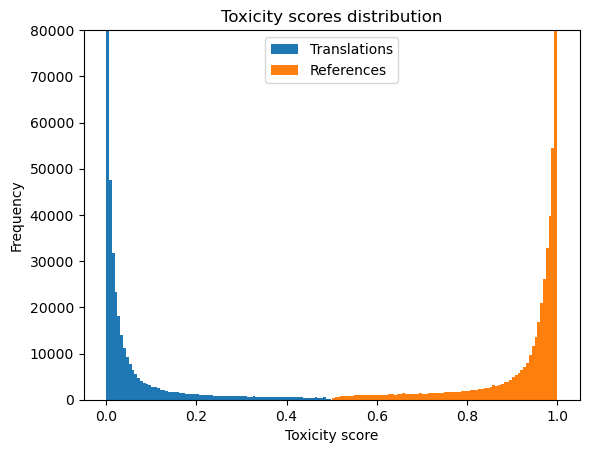

In [11]:
ax1 = df[:]['trn_tox'].plot(kind='hist', bins=80, label='Translations')
df[:]['ref_tox'].plot(kind='hist', bins=80, ax=ax1, label='References')
plt.xlabel('Toxicity score')
ax1.set_ylim(0, 80000)
plt.title('Toxicity scores distribution')

plt.legend(loc='upper center')
plt.show()

## Number of words

Now let's calculate the number of words in these sentences. I will be using string splitting by spaces and a couple of punctuation marks to get an approximate number of words in a sentences, which in turn is approximately the number of tokens in a sentence. This can be useful for example for specifiying `max_length` for tokenizer.  

In [14]:
flat = data.flatten_data(df)
tokens = flat['text'].str.split('[ ?.!;,-]')
lengths = tokens.apply(len)

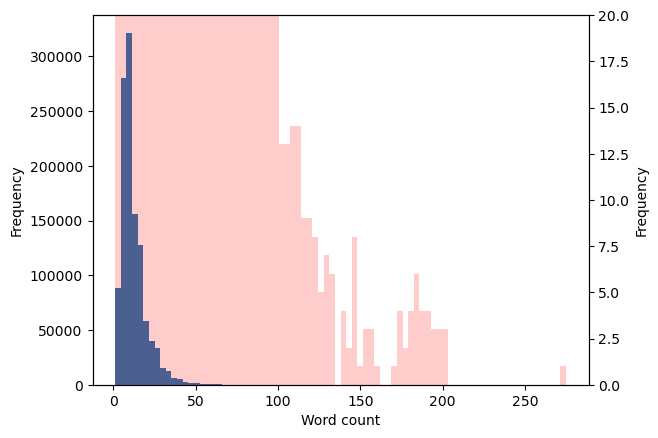

In [15]:
ax1 = lengths.plot(kind='hist', bins=80)
plt.xlabel('Word count')
ax2 = ax1.twinx()
lengths.plot(kind='hist', bins=80, ax=ax2, alpha=0.2, color='red')
ax2.set_ylim(0, 20)
plt.title('Word count distribution')

plt.show()

Note: red transparent histogram is just a scaled version of the blue one

As we can see, most of the sentences are under 50 words. Sepcifically, we can also compute that the amount of sentences containing less than 64 words is about 99.9% of the whole dataset:

In [18]:
np.sum(lengths < 64) / len(lengths)

0.998952017820024